In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import abspath

import pickle
from scipy import interp

# Import some classifiers and some others dependencies.
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.model_selection import train_test_split
from sklearn import metrics

### Functions to Evaluate

In [23]:
# ROC -> Receiver Operating Characteristic
def plot_roc_curve(fpr, tpr, roc_auc, k):
    # Config the plot.
    plt.figure(figsize=(10, 10))
    plt.grid()
    plt.plot([0, 1], [0, 1], ls='--')
    plt.ylim([-0.01, 1.01])
    plt.xlim([-0.01, 1.01])
    plt.xlabel('Taxa de Falsos Positivos', size=16)
    plt.ylabel('Taxa de Verdadeiros Positivos', size=16)

    linspace = np.linspace(0, 1, 100)

    # Calc the mean roc.
    int_tpr = [interp(linspace, fpr[i], tpr[i]) for i in range(k)]
    mean_tpr = np.mean(int_tpr, axis=0)

    # plot all roc curves for each fold and the average roc curve.
    for i in range(k):
        plt.plot(fpr[i], tpr[i], label=f'fold {i}, Área: {roc_auc[i]:.4f}')
    plt.plot(linspace, mean_tpr, label=f'Curva Média, Área: {auc(linspace, mean_tpr):.4f} (+/- {np.std(roc_auc)*2:.2f})')

    # plot the graphic.
    plt.legend(prop={'size': 16})
    plt.show()
    #plt.savefig('knn.png')


def evaluate_k_fold(model, X, y, k, verbose=False):
    fpr = []
    tpr = []
    roc_auc = []

    skf = StratifiedKFold(k)

    i=0
    # train and test the model for each `k` fold in all the data.
    for train_idx, test_idx in skf.split(X, y):
        if verbose:
            print(f'-- Running with {i}th fold.')
        model.fit(X.iloc[train_idx], y[train_idx])
        pred = model.predict_proba(X.iloc[test_idx])

        # compute micro-average ROC curve and ROC area.
        temp_fpr, temp_tpr, _ = roc_curve(y[test_idx], pred[:, 1])

        fpr.append(temp_fpr)
        tpr.append(temp_tpr)
        roc_auc.append(auc(temp_fpr, temp_tpr))
        i += 1

    # plot the graphic.
    plot_roc_curve(fpr, tpr, roc_auc, k)


def evaluate_metrics(model, X, y, split=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)
    y_pred = model.fit(X_train, y_train).predict(X_test)

    print('Evaluation:')
    # accuracy
    print('Acc: \t', metrics.accuracy_score(y_test, y_pred))
    # mean Absolute Error
    print('MSE: \t', metrics.mean_absolute_error(y_test, y_pred))
    # root Mean Squared Error
    print('RMSE: \t', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('\nConfusion Matrix:\n', metrics.confusion_matrix(y_test,y_pred))
    print('\nClassification Reports:\n', metrics.classification_report(y_test,y_pred))

In [13]:
def save_model(model, filename):
  # Save a trained model to file
  pickle.dump(model, open(filename, 'wb'))

def restore_model(filename):
  # Restore a trained model from a file.
  return pickle.load(open(filename, 'rb'))
  

### Data Import

In [14]:
public_data = pd.read_csv(abspath('./data/features/public_lexical.csv'))
df = public_data.sample(frac=1).reset_index(drop=True)
x = df.drop(['class'], axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1508458, 13) (1508458,)
(646482, 13) (646482,)


# Classification

### Decision Tree

/tmp/ipykernel_25289/1852750852.py:15: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  int_tpr = [interp(linspace, fpr[i], tpr[i]) for i in range(k)]


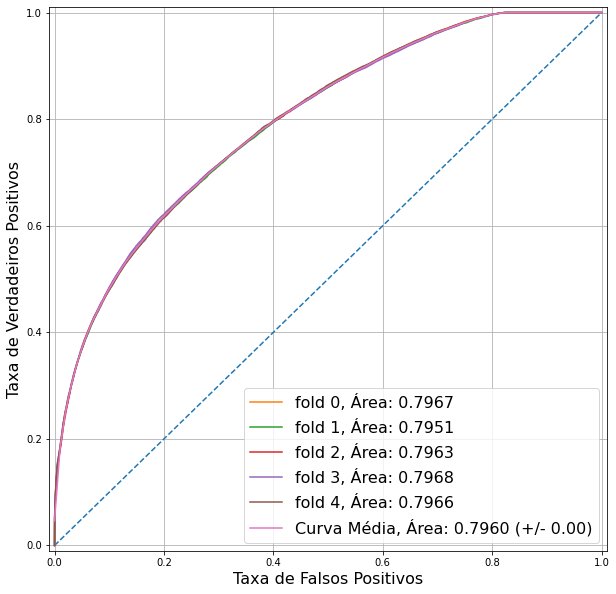

Evaluation:
Acc: 	 0.9454416364260722
MSE: 	 0.054558363573927814
RMSE: 	 0.23357731819234465

Confusion Matrix:
 [[606696   1866]
 [ 33405   4515]]

Classification Reports:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97    608562
           1       0.71      0.12      0.20     37920

    accuracy                           0.95    646482
   macro avg       0.83      0.56      0.59    646482
weighted avg       0.93      0.95      0.93    646482



<Figure size 432x288 with 0 Axes>

In [24]:
# You can play around with the hyperparameters to achieve a slightly better result
classifier = DecisionTreeClassifier(max_depth=500, max_features=None, min_samples_leaf=20, min_samples_split=2)

evaluate_k_fold(classifier, x, y, 5)
evaluate_metrics(classifier, x, y, split=0.3)

#save_model(classifier, 'models/decision_tree.pkl')

### Random Forest

In [ ]:
classifier = RandomForestClassifier(bootstrap=False, criterion='gini', max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=5, n_estimators=100, n_jobs=-1)

evaluate_k_fold(classifier, x, y, 10, verbose=True)
evaluate_metrics(classifier, x, y, split=0.3)

# save_model(classifier, 'models/random_forest.pkl')

-- Running with 0th fold.
-- Running with 1th fold.


### K Nearest  Neighbors

In [ ]:
classifier = KNeighborsClassifier(n_neighbors=50, metric='euclidean', weights='distance', n_jobs=-1)

evaluate_k_fold(classifier, x, y, 10, verbose=True)
evaluate_metrics(classifier, x, y, split=0.2)

# save_model(classifier, 'models/knn.pkl')